In [1]:
%matplotlib inline
import math
import glob
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats
from astropy.table import QTable
from astroquery.jplhorizons import Horizons
from photutils import centroid_com,centroid_sources
from photutils import CircularAperture, aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus
from astropy.wcs import utils
from scipy.interpolate import UnivariateSpline
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_541862/3206826948.py:17: DeprecationWarning: `photutils.centroid_com` is a deprecated alias for `photutils.centroids.centroid_com`. Instead, please use `from photutils.centroids import centroid_com` to silence this warning.
  from photutils import centroid_com,centroid_sources
/tmp/ipykernel_541862/3206826948.py:17: DeprecationWarning: `photutils.centroid_sources` is a deprecated alias for `photutils.centroids.centroid_sources`. Instead, please use `from photutils.centroids import centroid_sources` to silence this warning.
  from photutils import centroid_com,centroid_sources


In [2]:
path = '/home/jmurtagh/143P/'
Msun_r = -26.93
Msun_i = -27.05
rho = 10000
fitses = []
afrho_r = []
afrho_r_err = []
afrho_rcor = []
afrho_rcor_err = []
afrho_i = []
afrho_i_err = []
afrho_icor = []
afrho_icor_err = []
mag = []
mag_err = []
filters = []
date = []
mjd = []
alpha = []
rh = []

''' read in phase function for correcting to 0 degs. use univariate spline to 
    interpolate between every degree phase angle so as to get accurate phase function
    values later on '''
phase = ascii.read('/home/jmurtagh/phase.tbl', delimiter=' ')
spl = UnivariateSpline(phase.columns[0], phase.columns[1])
spl.set_smoothing_factor(0)
alpha_list = np.arange(0, 180, 0.0001)

''' read in fits files from desired path and add them to list to be analysed '''
for name in sorted(glob.glob(path+'*.fits')):
    fitses.append(name)

for i in range(len(fitses)):
    ''' read in the fits file and open up image data and header '''
    fname = fitses[i][fitses[i].find('ztf_'):]
    hdu = fits.open(path+fname)
    imgdiff = hdu[0].data
    hdr = hdu[0].header
    
    ''' take the time of observation from the fits header and use it to create 
        a date range for the epochs for astroquery by adding on one day.  '''
    dtime = Time(f'{hdr["OBSMJD"]}', format = 'mjd')
    dtime.format = 'iso'
    dtime2 = dtime + timedelta(days=1)
    
    ''' query jpl horizons using the date range and with the object id found on
        the online jpl horizons service first '''
    obj = Horizons(id='90001051', location='I41', epochs={'start':dtime.iso, 'stop':dtime2.iso, 'step':'1d'})
    eph = obj.ephemerides(quantities='1,19,20,24,39') #1 = RA + DEC (/decimal degrees, icrf), 19(r) = heliocentric comet dist (/AU), 20(delta) = observer-comet dist (/AU), 24(alpha) = phase angle (/degrees)
    
    ''' using small angle & s=r*theta, calculate the aperture radius in pixels
        for a 10^4km radius aperture. header contains scale of arcsecs/pixel '''
    delta_au = eph['delta'][0] * u.au
    delta_km = delta_au.to(u.km)
    theta_rad = ((10000*u.km)/(delta_km)) * u.rad
    theta_arcs = theta_rad.to(u.arcsec)
    pix = theta_arcs / hdr['PIXSCALE'] * (1/u.arcsec)
    
    ''' read in relevant details for calculations from header '''
    exptime = hdr['EXPTIME']
    gain = hdr['GAIN']
    rdnoise = hdr['READNOI']
    dark = hdr['DARKCUR']
    zp = hdr['MAGZP']
    wcs = WCS(hdr)
    
    ''' use RA & DEC guesses from jpl horizons to create skycoord object, turn those 
        into pixel values, and then use centroid_sources to hone in on object in image '''
    coords = SkyCoord(ra=eph['RA'][0], dec=eph['DEC'][0], frame='icrs', unit='deg')
    x, y = wcs.world_to_pixel(coords)
    xcent, ycent = centroid_sources(imgdiff, x, y, box_size=10, centroid_func=centroid_com)
    
    ''' using pixel scale calculated, create circular aperture and annulus around object
        with desired radii '''
    ap_radii=float(pix)
    aperture = CircularAperture((xcent[0],ycent[0]), r=ap_radii)
    annulus_aperture = CircularAnnulus((xcent[0],ycent[0]), r_in=4*float(pix), r_out=5*float(pix))
    annulus_mask = annulus_aperture.to_mask(method='center')
    
    ''' perform photometry on image '''
    phot = aperture_photometry(imgdiff, aperture)
    
    ''' '''
    annulus_data = annulus_mask.multiply(imgdiff)
    annulus_data_1d = annulus_data[annulus_mask.data > 0]
    _, bkg_median, _ = sigma_clipped_stats(annulus_data_1d)
    phot['sky_bkg'] = bkg_median
    
    ''' '''
    phot['aper_sky'] = bkg_median * aperture.area
    phot['counts_minus_sky'] = phot['aperture_sum'] - phot['aper_sky'] 
    n_target=phot['counts_minus_sky']
    n_sky=phot['aper_sky']
    n_dark=dark*exptime
    err_electrons=np.sqrt(gain*n_target + gain*n_sky + n_dark*aperture.area + rdnoise*rdnoise*aperture.area)
    err_adus=err_electrons/gain
    phot['uncertainty'] = err_adus
    
    ''' calculate a magnitude from the counts calculated. if the magnitude returns a nan
        value, ignore it and skip to the next image as it will be unusable data. otherwise,
        plot the image centered on the comet with the aperture overplotted and magnitude
        and filter labelled, and append any useful details to lists at end'''
    m = -2.5 * np.log10(phot['counts_minus_sky']) + zp
    
    if math.isnan(m[0]) == True:
        pass
    else:
#         fig = plt.figure()
#         ax = plt.subplot(projection = wcs)
#         plt.imshow(imgdiff, cmap='gray', norm=ImageNormalize(imgdiff, interval=ZScaleInterval()))
#         plt.xlim(int(xcent)-50, int(xcent)+50)
#         plt.ylim(int(ycent)-50, int(ycent)+50)
        
#         plt.grid(color='w', which='major')
#         plt.xlabel('RA')
#         plt.ylabel('DEC')
        
#         ap_patches = aperture.plot(color='white', lw=2)
#         ann_patches = annulus_aperture.plot(color='red', lw=2)
        
#         plt.title(f'{dtime}')
#         plt.legend([ap_patches],[f'Mag: {m[0]:.4}  Filter: {hdr["FILTER"]}'])
#         plt.show()
        
        ''' find the index of the value of alpha in the phase function curve. need to 
            round alpha_list to 4dp as there are floating point issues in finding matches 
            otherwise. then find value of phase function for that phase angle '''
        idx = np.where(eph['alpha'][0] == np.round(alpha_list,4))[0][0]
        phasefunc = spl(alpha_list)[idx]
        
        mag.append(m[0])
        filters.append(hdr['FILTER'])
        date.append(dtime)
        mjd.append(hdr['OBSMJD'])
        alpha.append(eph['alpha'][0])
        rh.append(eph['r'][0])
        
        ''' calculate the afrho value for the specified filter that the image being analysed
            is in (found in the header value) using the magnitude of the sun in said filter. 
            uncertainties are propagated using standard formulae, split into parts as it is 
            very hard to follow the lines of thought of each error on one single line'''
        if hdr['FILTER'] == 'ZTF r' or 'ZTF_r':
            afrho = (((10**(-0.4 * (m[0] - Msun_r))) *(4 * eph['r'][0]**2 * delta_km**2 )/(rho * u.km)).to(u.cm)).value
            
            delr = delta_km.value**2 * (eph['r'][0]*u.au).to(u.km).value**2
            a = (2 * delta_km * eph['r_3sigma'][0]).value
            b = (2 * (eph['r'][0] * u.au).to(u.km) * eph['r_3sigma'][0]).value
            c = (delr * np.sqrt((a/delta_km.value**2)**2 + (b/(eph['r'][0] * u.au).to(u.km).value**2)**2))
            d = 4 * c / rho
            e = 2.5 * phot['uncertainty'][0] / (phot['counts_minus_sky'][0] * np.log(10))
            f = 10**(-0.4*(m[0] - Msun_r)) * np.log(10) * np.sqrt(e**2 + 0.02**2)
            x = 10**(-0.4*(m[0]-Msun_r))
            y = 4 * delta_km.value**2 * (eph['r'][0]*u.au).to(u.km).value**2 / rho
            g = afrho * np.sqrt((f/x)**2 + (d/y)**2)
            
            mag_err.append(e)
            afrho_r_err.append(g)
            afrho_r.append(afrho)
            afrho_rcor.append(afrho/phasefunc)
            afrho_rcor_err.append(g/phasefunc)
        else:
            afrho = (((10**(-0.4 * (m[0] - Msun_i))) *(4 * eph['r'][0]**2 * delta_km**2 )/(rho * u.km)).to(u.cm)).value
            
            delr = delta_km.value**2 * (eph['r'][0]*u.au).to(u.km).value**2
            a = (2 * delta_km * eph['r_3sigma'][0]).value
            b = (2 * (eph['r'][0] * u.au).to(u.km) * eph['r_3sigma'][0]).value
            c = (delr * np.sqrt((a/delta_km.value**2)**2 + (b/(eph['r'][0] * u.au).to(u.km).value**2)**2))
            d = 4 * c / rho
            e = 2.5 * phot['uncertainty'][0] / (phot['counts_minus_sky'][0] * np.log(10))
            f = 10**(-0.4*(m[0] - Msun_r)) * np.log(10) * np.sqrt(e**2 + 0.02**2)
            x = 10**(-0.4*(m[0]-Msun_r))
            y = 4 * delta_km.value**2 * (eph['r'][0]*u.au).to(u.km).value**2 / rho
            g = afrho * np.sqrt((f/x)**2 + (d/y)**2)
            
            mag_err.append(e)
            afrho_i_err.append(g)
            afrho_i.append(afrho)
            afrho_icor.append(afrho/phasefunc)
            afrho_icor_err.append(g/phasefunc)

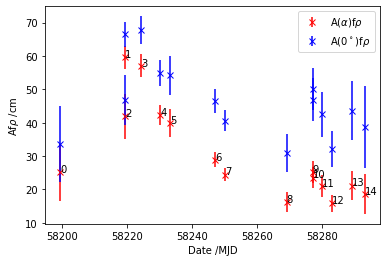

In [3]:
''' create plot of afrho in r filter as a function of mjd with perihelion marked by dashed
    line '''
fig=plt.figure()
plt.errorbar(mjd, afrho_r, yerr=afrho_r_err, fmt='rx', label = r'A($\alpha$)f$\rho$')
plt.errorbar(mjd, afrho_rcor, yerr=afrho_rcor_err, fmt='bx', label = r'A($0^\circ$)f$\rho$')
plt.xlabel(r'Date /MJD')
plt.ylabel(r'Af$\rho$ /cm')

n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i, txt in enumerate(n):
    plt.annotate(txt, (mjd[i], afrho_r[i]))
    
plt.legend()
plt.show()

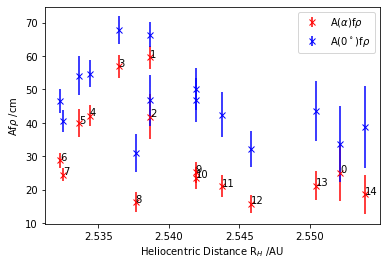

In [4]:
fig=plt.figure()
plt.errorbar(rh, afrho_r, yerr=afrho_r_err, fmt='rx', label = r'A($\alpha$)f$\rho$')
plt.errorbar(rh, afrho_rcor, yerr=afrho_rcor_err, fmt='bx', label = r'A($0^\circ$)f$\rho$')
plt.xlabel(r'Heliocentric Distance R$_H$ /AU')
plt.ylabel(r'Af$\rho$ /cm')

n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i, txt in enumerate(n):
    plt.annotate(txt, (rh[i], afrho_r[i]))
    
plt.legend()
plt.show()

17.494956552858433 58199.3344329 0.010714459144870236 2.552149510946
16.473741065697393 58219.2808565 -0.002771571590129973 2.538663480211
16.856306818512365 58219.3044792 -0.002783169820129938 2.538651881981
16.524386076414917 58224.2776968 -0.004992196790130077 2.536442855011
16.866611790597858 58230.2511921 -0.007031147412130068 2.534403904389
16.937234213981704 58233.1890856 -0.007787090208129843 2.533647961593
17.38813128691846 58247.2318866 -0.00914370919912999 2.532291342602
17.593807081161245 58250.2336343 -0.008948789956130021 2.532486261845
18.252451257571952 58269.1646759 -0.0037925675341301535 2.537642484267
17.87418355952232 58277.2319444 0.0004518668158701722 2.541886918617
17.94741408078834 58277.252963 0.0004645099558699961 2.541899561757
18.10382957546049 58280.1712616 0.0022995254638700224 2.543734577265
18.45926941434964 58283.1893981 0.004363121624869848 2.545798173426
18.223239897693873 58289.2147106 0.008984081604869854 2.550419133406
18.418005273499205 58293.2351

<function matplotlib.pyplot.show(close=None, block=None)>

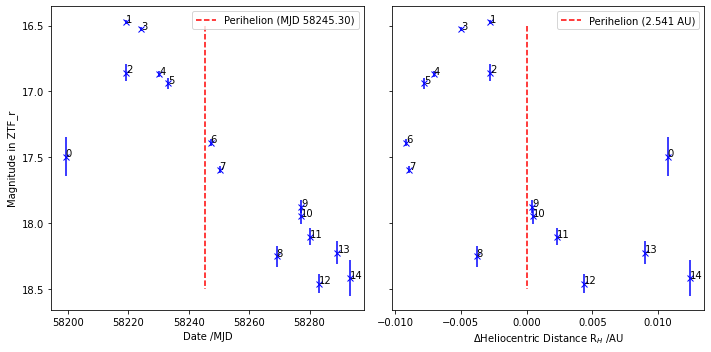

In [5]:
''' create plot of the variation in magnitude in r filter as a function of mjd, with
    perihelion marked by dashed line '''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.errorbar(mjd, mag, yerr=mag_err, fmt='bx')
ax1.invert_yaxis()
perihelion_jd = 2458245.80250
perihelion_mjd = perihelion_jd - 2400000.5
peri = ax1.vlines(perihelion_mjd, ymin=16.5, ymax=18.5, linestyle='dashed', color='r', label = f'Perihelion (MJD {perihelion_mjd:.2f})')
ax1.set_xlabel('Date /MJD')
ax1.set_ylabel('Magnitude in ZTF_r')
ax1.legend(loc='upper right')

dist = np.array(rh) - 2.54143505180113
ax2.errorbar(dist, mag, yerr=mag_err, fmt='bx')
ax2.invert_yaxis()
peri  = ax2.vlines(0, ymin=16.5, ymax=18.5, linestyle='dashed', color='r', label = f'Perihelion (2.541 AU)')
ax2.set_xlabel('$\Delta$Heliocentric Distance R$_H$ /AU')
ax2.invert_yaxis()
ax2.legend(loc = 'upper right')

n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

for i, txt in enumerate(n):
    ax1.annotate(txt, (mjd[i], mag[i]))
    ax2.annotate(txt, (dist[i], mag[i]))

for i in range(len(mag)):
    print(mag[i], mjd[i], dist[i], rh[i])
    
# idx = np.where(rh == np.min(rh))[0][0]
# print(idx)
# rh[0:idx] *= int(-1.0)
print(rh)

plt.tight_layout()
plt.show

In [6]:
idx = np.where(rh == np.min(rh))[0][0]
for i in range(idx):
    rh[i] = rh[i] * -1

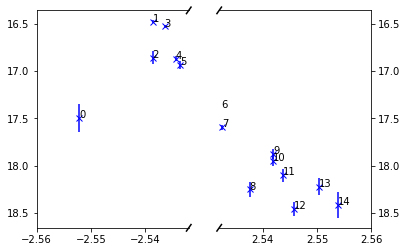

In [16]:

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)
ax1.errorbar(rh[0:idx], mag[0:idx], yerr=mag_err[0:idx], fmt='bx')
ax2.errorbar(rh[idx+1:], mag[idx+1:], yerr=mag_err[idx+1:], fmt='bx')
ax2.invert_yaxis()

ax1.set_xlim(-2.56,-2.532)
ax2.set_xlim(2.532, 2.56)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.tick_params(labelright='off')
ax2.yaxis.tick_right()
d = .015 
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)




n = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

for i, txt in enumerate(n):
    ax1.annotate(txt, (rh[i], mag[i]))
    ax2.annotate(txt, (rh[i], mag[i]))